In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Represent state as both a number and state data
Transformation matrix requires that state has to be turned into a number, for readability the class allows both.
How to map game state (inning, half, outs, bases, home score, away score) is somewhat arbitrary, and choices are mostly done for simplicity's sake.

A state is represented as an inning (which includes the half), the bases (represented by one number from converting the 3 digit binary base states), outs, and the score (home team - away team).

    inning = [0,17]
    outs = [0,2]
    bases = [0,8]
    score = [-8,8] A larger score range may be excessive

Matrix is finite, so data that has extra innings or a score difference greater than 8 (negative or positive) are thrown out.

Converting from state to number:

    Every unique state maps to a unique number: [0, # of possible states - 1]
    Simple conversion: (score + 8)*18*8*3 + (inning)*8*3 + (bases)*3 + (outs)
    Adding 8 to score is to change the range of score from [-8, 8] to [0, 16]

Lastly to determine when a game has ended a couple flags are used by reserving 3 states (home win, home loss, draw) which normally could never occur:
    
    (Since the away team bats first, score can't be positive in the first inning)
    Home win flag: inning = 0, outs = 0, bases = 0, score = 1
    Away win flag: inning = 0, outs = 0, bases = 0, score = 2
    Draw flag:     inning = 0, outs = 0, bases = 0, score = 3
    
    Note that while the draw flag is still available to use, it shouldn't ever be utilized.

In [2]:
#gameState represents any state in a baseball game, each state can be represented by either members or as one number
#note: end flags, they are inning = 0, outs = 0, bases = 0, score = 1,2,3 (since these states are impossible in normal play)
#if flag score is 1 (home win), 2 (away win), 3 (draw state at end of 17th (9th) inning)
class gameState:
    scoreRange = 8 #[-scoreRange, scoreRange]
    
    inning = 0 #[0,17] since each of the 9 innings are either in the top or the bottom
    outs = 0 #[0, 2] number of outs
    bases = 0 #[0,7] binary representation, i.e. 6 (110) has runners on 2nd and 3rd
    score = 0 #score = homeTeamScore - awayTeamScore, for simplicity score = [-8, 8]

    def setFromInfo(self, inn, out, bas, scor): #construct from data, note: base should be a 3 element list like [0,1,1]
        if(inn > 17):
            inn = 16 + int(inn % 2 == 0)
        self.inning = inn
        self.outs = out
        self.bases = 4*bas[2] + 2*bas[1] + bas[0] #conversion from list format to single number
        
        self.score = max(-self.scoreRange, min(self.scoreRange, scor)) #score between range
        
    def setFromData(self, inn, out, bas, scor): #construct from data, note: base should be [0,7]
        if(inn > 17):
            inn = 16 + int(inn % 2 == 0)
        self.inning = inn
        self.outs = out
        self.bases = bas
        
        self.score = max(-self.scoreRange, min(self.scoreRange, scor)) #score between range

    def setFromNum(self, numEquiv): #construct from number, map number to gameState
        self.outs = numEquiv % 3
        numEquiv = numEquiv // 3
        
        self.bases = numEquiv % 8
        numEquiv = numEquiv // 8
        
        self.inning = (numEquiv % 18)
        numEquiv = numEquiv // 18
        
        self.score = (numEquiv % (self.scoreRange*2 + 1)) - self.scoreRange
        
    def __str__(self): #for convient printing, note bases are printed as 1,2,3 not 3,2,1
        return ("{'Inning': " + str(self.inning) + ", " 
            + "'Outs': " + str(self.outs) + ", "
            + "'Bases': " + str(self.bases % 2) + str((self.bases >> 1) % 2) + str(self.bases >> 2) + ", "
            + "'Score': " + str(self.score) + "}")
    
    def toNum(self): #map gameState to number
            return (self.score + self.scoreRange)*18*8*3 + (self.inning)*8*3 + (self.bases)*3 + (self.outs)
    
    def setEndFlagState(self, lastState): #set the end flag state from the last state of the game, asssume lastState is an end
        self.inning = 0
        self.outs = 0
        self.bases = 0
        self.score = 3 #draw
        if(lastState.score < 0): #away win
            self.score = 2
        elif(lastState.score > 0): #home win
            self.score = 1
        else: #game ended in overtime or last inning
            if(lastState.inning % 2 == 0): #away team batted last
                self.score = 2 #away team won
            else: #home team batted last
                self.score = 1 #home team won
                     
    def isEndState(self): #check if the state is an end state
        if(self.inning != 0 or self.outs != 0 or self.bases != 0): #not an end state if any of these aren't true
            return False
        return (self.score >= 1 and self.score <= 3) #is an end flag if score is between [1, 3]
    def getEndResult(self): #return the value of an end state 1 = home win, -1 away win, 0 draw (assumes the state is an end state)        
        if(self.score == 1):
            return 1 #home win
        elif(self.score == 2):
            return -1 #away win
        else:
            return 0 #draw
#gameStates options: 18*3*8*17 = 7334

def getStateFromLine(line): #line in format of: inning, top/bottom, out, vis. score, home score, 1st,2nd,3rd, newGameFlag
    lineData = line.split(',')
    
    #convert from the line to the state
    inning = (int(lineData[0])-1)*2 + int(lineData[1]) #map inning and bottom/top for state
    outs = int(lineData[2])
    bases = [int(lineData[5] != '""'), int(lineData[6] != '""'), int(lineData[7] != '""')] #convert to bases
    score = int(lineData[4]) - int(lineData[3]) #home - vis score
    
    newGameStart = lineData[8][1] == 'T' #weird way of checking string, but it works
    
    state = gameState()
    state.setFromInfo(inning,outs,bases,score)
    return state, newGameStart

#NOTE THE isValidTrans method is no longer being used
#catch "bad data", basically catches to high scoring games
def isValidTrans(stateCurr, stateNext): #verify that the state transition isn't an error
    if(stateCurr.inning > stateNext.inning): #innings only move forward
        #print(stateCurr, stateNext)
        return False;
        
    elif(stateCurr.inning < stateNext.inning):
        if(stateNext.bases != 0 or stateNext.outs != 0):
           # print(stateCurr, stateNext)
            return False #new inning bases/outs should reset
        else:
            return True #inning is properly reset
    #else stateCurr and stateNext are in the same inning
    
    #if next state has "worse" bases implies a change in score or outs
    if(stateCurr.bases >= stateNext.bases and stateCurr.outs == stateNext.outs and stateCurr.score == stateNext.score ):
        #print(stateCurr, stateNext)
        return False

    return True

In [3]:
fileName="test software\\FormattedData\\2010-2019StateData.txt"
dataFile = open(fileName, "r")

line = dataFile.readline()

stateCurr = gameState()
statePrev = gameState()
stateEnd = gameState()

matrixDimSize = (1+2*stateCurr.scoreRange)*18*8*3
print(matrixDimSize)
matrixDim = (matrixDimSize,matrixDimSize) #since 31*18*8*3

stateTran = np.zeros(matrixDim) #set the size of the large state transition matrix

totalGames = 0
homeWinGames = 0

statePrev, newGame = getStateFromLine(line) #avoid running into an error of writing the last game end
line = dataFile.readline() #read second line, not a newGame
while(line):
    stateCurr, newGame = getStateFromLine(line)
    if(not newGame):
        stateTran[statePrev.toNum()][stateCurr.toNum()] += 1 #add one to the entry
    else: #new game, put result of previous game
        stateEnd.setEndFlagState(statePrev) #get the flag from the end state
        #print(stateEnd, statePrev)
        stateTran[statePrev.toNum()][stateEnd.toNum()] += 1 #add one to the end state entry
        totalGames = totalGames + 1

    statePrev = stateCurr
    line = dataFile.readline() 
    
dataFile.close()

print("Total games: ", totalGames)

countStateMatrix = stateTran.copy()
#change the matrix to a probability matrix, i.e. matrix[y][x] is probability from going to x, given that you are at y
for row in range(matrixDim[0]):
    rowSum = sum(stateTran[row])
    if(rowSum != 0):
        stateTran[row] = stateTran[row] / rowSum
        
#win coordinates should have only 1 entry in their row, gaurenteed chance to return to iteself
stateEnd.setFromData(0,0,0,1) #home win
stateTran[stateEnd.toNum()][stateEnd.toNum()] = 1
stateEnd.setFromData(0,0,0,2) #home loss
stateTran[stateEnd.toNum()][stateEnd.toNum()] = 1
stateEnd.setFromData(0,0,0,3) #draw
stateTran[stateEnd.toNum()][stateEnd.toNum()] = 1

#print any bad data
for row in range(matrixDim[0]):
    rowSum = sum(stateTran[row])
    if(rowSum < 1 - .001 or rowSum > 1 + .001): #row doesn't sum to 1, allow permitted if no entry leads to this row
        if(sum(stateTran[:,row]) != 0): #if no row leads to the empty row
            print(row, ' ' , rowSum)

7344
Total games:  24296


take a 24x24 matrix and a large general matrix and infer the large matrix for the player
use the reasoning, for all cells in the large matrix, find the corresponding 24x24 and scale

An index in the small matrix is decoded like the big matrix, i in the big matrix corresponds to i % 24 in the small one. 

In [4]:
def getGenSmallMatrix(M, C): #the 24x24 for a general player, M is the prob matrix, C is the count matrix
    smallMatrix = np.zeros((24,24))
    
    for i in range(0,len(M)):
        for j in range(0, len(M[0])):
            newI = i % 24
            newJ = j % 24
            smallMatrix[newI,newJ] += C[i,j]
            
    #make small matrix a trans matrix
    for row in range(24):
        rowSum = sum(smallMatrix[row])
        if(rowSum != 0):
            smallMatrix[row] = smallMatrix[row] / rowSum
    return smallMatrix

def getBigMatrix(M, p, pGen): #M is the prob matrix, p is the player, pGen is the general player
    
    playerM = np.copy(M)
    for i in range(0,len(M)):
        for j in range(0, len(M[0])):
            newI = i % 24
            newJ = j % 24
            
            if(pGen[newI,newJ] != 0): #no data, use from M
                playerM[i,j] = M[i,j]
            else:
                playerM[i,j] = p[newI,newJ] / pGen[newI,newJ]
    return playerM

def showMatrix(M, size=1): #M should be probability matrix
    matrixPixels = np.zeros((len(M),len(M[0]),3), dtype=np.uint8)
    matrixPixels[:,:,0] = M*255
    matrixPixels[:,:,1] = M*255
    matrixPixels[:,:,2] = M*255
    
    matrixPixels[M==0] = [128,0,0]
                            
    fig, ax = plt.subplots(figsize=(15*size,15*(len(M)/len(M[0]))*size))
    ax.imshow(matrixPixels)
    return fig, ax

(24, 24)


<ipython-input-4-9fef69b39e57>:28: RuntimeWarning: invalid value encountered in double_scalars
  playerM[i,j] = p[newI,newJ] / pGen[newI,newJ]


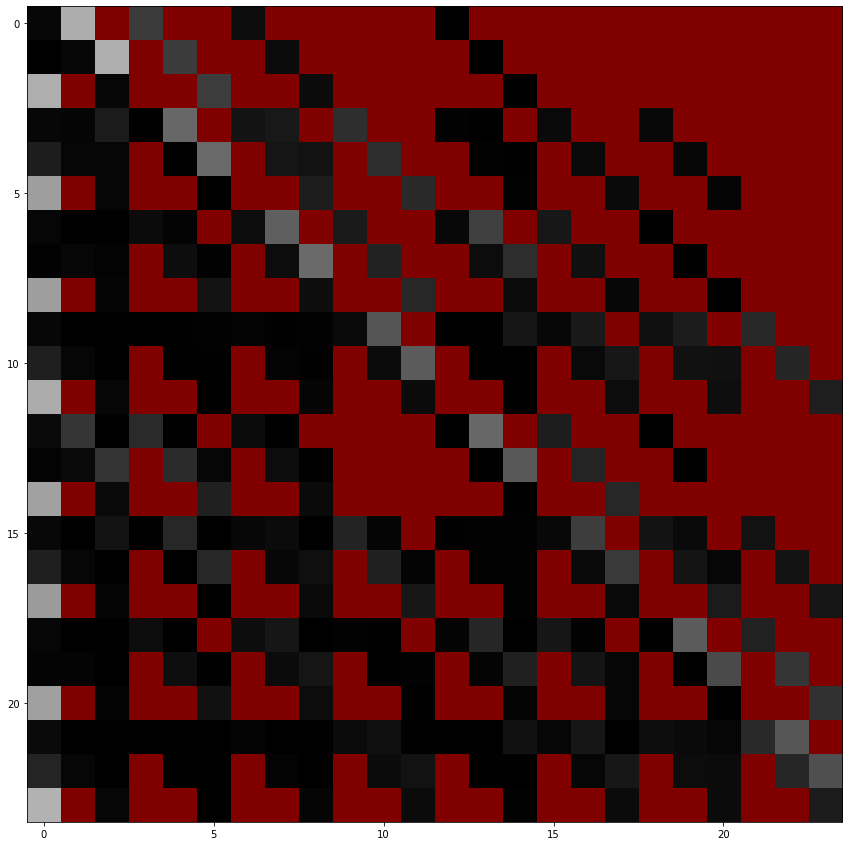

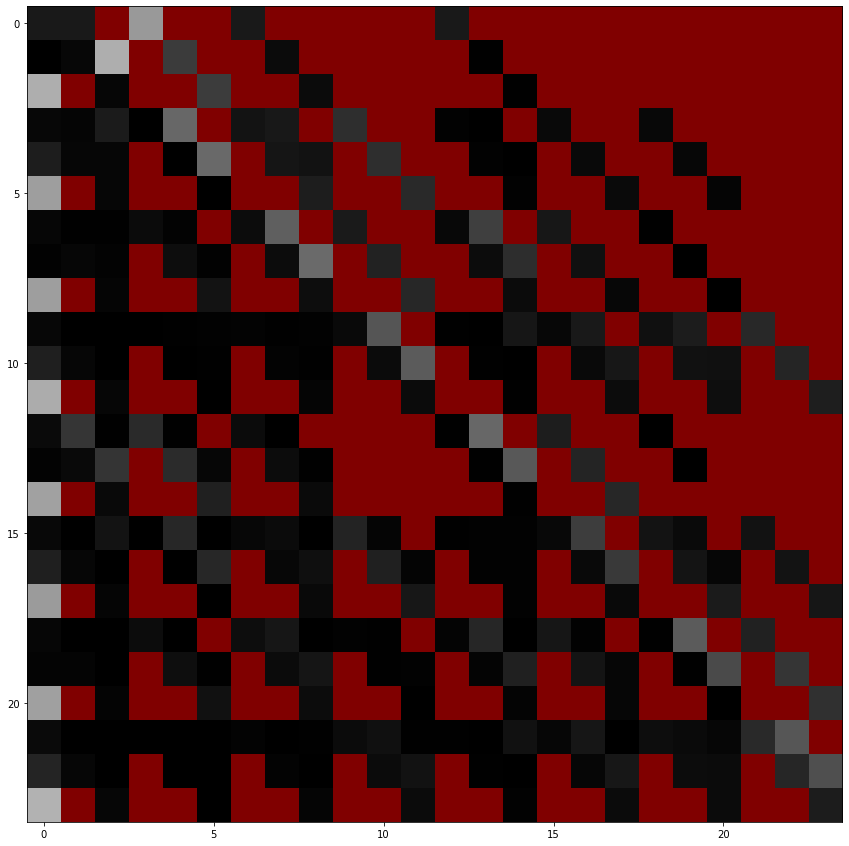

In [5]:
smallMatrix = getGenSmallMatrix(stateTran, countStateMatrix)

print(np.shape(smallMatrix))
fig, ax = showMatrix(smallMatrix)

playerMatrix = smallMatrix.copy() #just use a general player for now
playerMatrix[0, 1*3 + 0] = .6 #on first
playerMatrix[0, 2*3 + 0] = .1 #on second
playerMatrix[0, 4*3 + 0] = .1 #on third
playerMatrix[0, 0*3 + 0] = .1 #home run
playerMatrix[0, 0*3 + 1] = .1 #out

playerMatrixBig = getBigMatrix(stateTran, playerMatrix, smallMatrix)

fig2, ax2 = showMatrix(playerMatrix)

In [17]:
#not complete, scores should be different.
def getAwayMatrix(M): #given a big matrix, cut out all odd innings
    D = np.zeros((int(len(M)/2), int(len(M)/2)))
    
    #copy over correct rows
    for i in range(0, 9):
        rows = M[2*i*24:2*i*24 + 24] #even inning segment
        for j in range(0, 9): #even inning segments (column wise)
            D[i*24:i*24 + 24, j*24:j*24 + 24] = rows[:,2*j*24:2*j*24 + 24]
    
    for i in range(0,len(D)):
        prob = 1 - sum(D[i]) #missing prob on this row, add to the prob to the next inning
        
        inning = i % 24
        D[i][(inning+1)*24] += prob
    
    
    return D

def getHomeMatrix(M): #given a big matrix, cut out all even innings
    A = np.zeros((int(len(M)/2), int(len(M)/2)))
    
    #copy over correct rows
    for i in range(0, 9):
        rows = M[24 + 2*i*24:24 + 2*i*24 + 24] #odd inning segment
        for j in range(0, 9): #even inning segments (column wise)
            A[24 + i*24:24 + i*24 + 24, 24 + j*24:24 + j*24 + 24] = rows[:,24 + 2*j*24:24 + 2*j*24 + 24]
    
    for i in range(0,len(A)):
        prob = 1 - sum(A[i]) #missing prob on this row, add to the prob to the next inning
        
        inning = i % 24
        A[i][(inning+1)*24] += prob
    
    
    return A

In [19]:
matrixAway = getAwayMatrix(stateTran)
matrixHome = getHomeMatrix(stateTran)

print(np.shape(matrixAway), np.shape(stateTran))

(3672, 3672) (7344, 7344)
